In [1]:
import cv2 as cv
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import pytesseract
#kasutame pytesseracti libraryt numbrite äratundmiseks
pytesseract.pytesseract.tesseract_cmd = 'C:\\Program Files\\Tesseract-OCR\\tesseract'

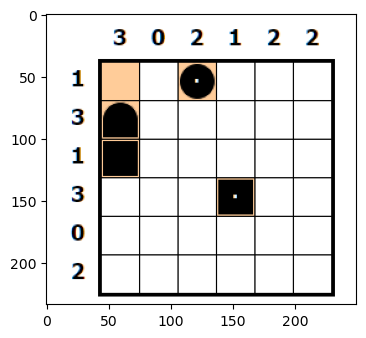

In [2]:
#Loe pilt
img_rgb = cv.imread('images/puzzle6.PNG')
# Mustvalge igaks juhuks
img_gray = cv.cvtColor(img_rgb, cv.COLOR_BGR2GRAY)

plt.figure(figsize=(4,4))
plt.imshow(img_rgb)

In [3]:
#meetod matchTemplate kasutades ruutude asukohtade leidmiseks
#puzzle_rgb-pilt, folder - kaust(olenevalt suuruses images kausta sees olev kaust), templateFile - template mida kasutatakse
# allFound - järjend, kus kõik asukohad kirjas
def findTemplate(puzzle_rgb,folder,templateFile,allFound):
    template = cv.imread('images/' + folder + templateFile + '.PNG')
    templates = []
    #lisame template 4 erinevat pidi, et kõikvõimalikud leitakse
    templates.append(template)
    templates.append(cv.flip(template, 1))
    templates.append(cv.flip(template, -1))
    templates.append(cv.flip(template, 0))
    w, h = template.shape[::-2]
    for i in range(len(templates)):
        res = cv.matchTemplate(puzzle_rgb,templates[i], cv.TM_CCOEFF_NORMED)
        #0.82 hetkel maksimaalne threshold, mis leiab pea alati mingi versiooni lauast
        # kõrgema korral enamasti mingeid ruutusid ei leia
        threshold = 0.82
        loc = np.where(res >= threshold)
        for pt in zip(*loc[::-1]):
            alreadyThere = False
            for found in allFound:
                #iga leitud asukoha korral kontrollime ega tegemist pole juba leitud ruuduga
                if abs(found[0] - pt[0]) < 10 and abs(found[1]-pt[1]) < 10:
                    alreadyThere = True
                    break
            if not alreadyThere:
                #kui pole varem leitud ruut, lisame vastavalt nimele selle allFoundi
                #'None' template ehk hetkel tühi ruut on None tüüpi
                if templateFile == 'None':
                    allFound.append((pt[0],pt[1],None))
                #2 korral ehk poolringi taolisel ruudul on 4 erinevat varianti, nii et anname vastavalt järjekorrale õige variandi
                elif templateFile == '2':
                    allFound.append((pt[0],pt[1],int(templateFile)*(i+1)))
                else:
                    allFound.append((pt[0],pt[1],int(templateFile)))
                # rectangle(pilt, algusnurk (koordinaadid), lõppnurk, värv (BGR), joone paksus)
                cv.rectangle(puzzle_rgb, pt, (pt[0]+w, pt[1]+h), (0,255,255), 1)

    #plt.imshow(puzzle_rgb)
    

In [4]:
#meetod kõikide ruutude leidmiseks ja kontrolliks kas pikkus on vastav (variandid 6x6,8x8,10x10,15x15)
def getPuzzle(img_rgb):
    allFound = []
    sizes = [6,8,10,15]
    templates = ['None','0','1','2','5']
    #käime kõik variandid läbi alustades sellest, et vaatame, kas 6 kausta templatedega on 36 ruutu, 8 omadega 64 jne
    #ja siis ka kõik muud nagu nätieks 6 templatedega on 100 ruutu
    for i in range(len(sizes)):
        for j in range(len(sizes)):
            img_copy = img_rgb.copy()
            for template in templates:
                findTemplate(img_copy,str(sizes[j])+'/',template,allFound)
            comp = i+j
            #kui oleme järjendi lõppu jõudnud selle j korral, alustame algusest
            if comp >= len(sizes):
                comp -= len(sizes)
            if len(allFound) == sizes[comp]**2:
                return allFound
            allFound = []
    return None

In [5]:
currentPuzzle = getPuzzle(img_rgb)

In [6]:
#meetod ruutude sorteerimiseks ja seejärel rea ja veeru kaupa täpsustamiseks asukohta, et ühtlased read ja veerud saada
def fixNumbers(allFound):
    sortedSquares = sorted(allFound, key=lambda element: (element[1]))
    for i in range(len(sortedSquares)):
        if 0 < sortedSquares[i][1] - sortedSquares[i-1][1] < 20:
            sortedSquares[i] = (sortedSquares[i][0],sortedSquares[i-1][1],sortedSquares[i][2])
    sortedSquares = sorted(sortedSquares, key=lambda element: (element[0]))
    for i in range(len(sortedSquares)):
        if 0 < sortedSquares[i][0] - sortedSquares[i-1][0] < 20:
            sortedSquares[i] = (sortedSquares[i-1][0],sortedSquares[i][1],sortedSquares[i][2])
    sortedSquares = sorted(sortedSquares, key=lambda element: (element[1],element[0]))
    return sortedSquares

In [7]:
#lõplikusse järjendite järjendisse viimine
def coordinatesToArray(allFound):
    if allFound == None:
        return
    length = len(allFound)
    correct = None.
    #leiame suuruse
    possibleOptions = [36,64,100,225]
    for i in range(len(possibleOptions)):
        if possibleOptions[i] == length:
            correct = i
            break
    if correct == None:
        return
    #fikseerime numbrid
    sortedSquares = fixNumbers(allFound)
    fullMatrix = []
    possibleRows = [6,8,10,15]
    rowLength = possibleRows[correct]
    #viime ridadesse vastava reapikkuse kaupa
    for i in range(rowLength):
        row = [t[2] for t in sortedSquares[i*rowLength:i*rowLength+rowLength]]
        fullMatrix.append(row)
    return fullMatrix

In [8]:
#pytesseractiga numbrite leidmine
def findNumbers(img):
    h, w, c = img.shape
    #ainult numbreid 0st 9ni leidmine
    string = pytesseract.image_to_string(img,config='digits')
    """
    boxes = pytesseract.image_to_boxes(img)
    for b in boxes.splitlines():
        b = b.split(' ')
        img = cv.rectangle(img, (int(b[1]), h - int(b[2])), (int(b[3]), h - int(b[4])), (0, 255, 0), 2)
    plt.imshow(img)
    """
    #viime järjendisse
    horizontal = [int(i) for i in list(string.strip())]
    return horizontal
    

In [9]:
print(coordinatesToArray(currentPuzzle))

[[None, None, 1, None, None, None], [2, None, None, None, None, None], [5, None, None, None, None, None], [None, None, None, 5, None, None], [None, None, None, None, None, None], [None, None, None, None, None, None]]


In [10]:
findNumbers(img_rgb)

[3, 0, 2, 1, 2, 2]